In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [2]:
# import src.data.loader as loader
# import src.models.gps as gps
# import torch_geometric.data
# import bertviz
# # basic test on cora for dev purposes
# cora_data, num_classes = loader.load_clean_cora()
# print(isinstance(cora_data, torch_geometric.data.Data))
# print(cora_data)
# model = gps.GPS(cora_data, num_classes, pe_channels=5, hidden_channels=2, observe_attention=True, num_attention_heads=2)
# w = gps.train(model, cora_data)

# single_matrix = w[0][0]
# print(len(w[0]))
# print(w[0][0].shape)
# bertviz.model_view
# print(single_matrix.argmax(dim=1))
# train_acc, test_acc = gps.test(model, cora_data)
# print(f'Train Accuracy for Cora node-level classification: {train_acc}')
# print(f'Test Accuracy for Cora node-level classification: {test_acc}')



In [3]:
from src.data.synthetic import gengraph

In [4]:
import networkx as nx
from networkx import draw

feat_dict[0]["feat"]: float32
G.nodes[0]["feat"]: float32


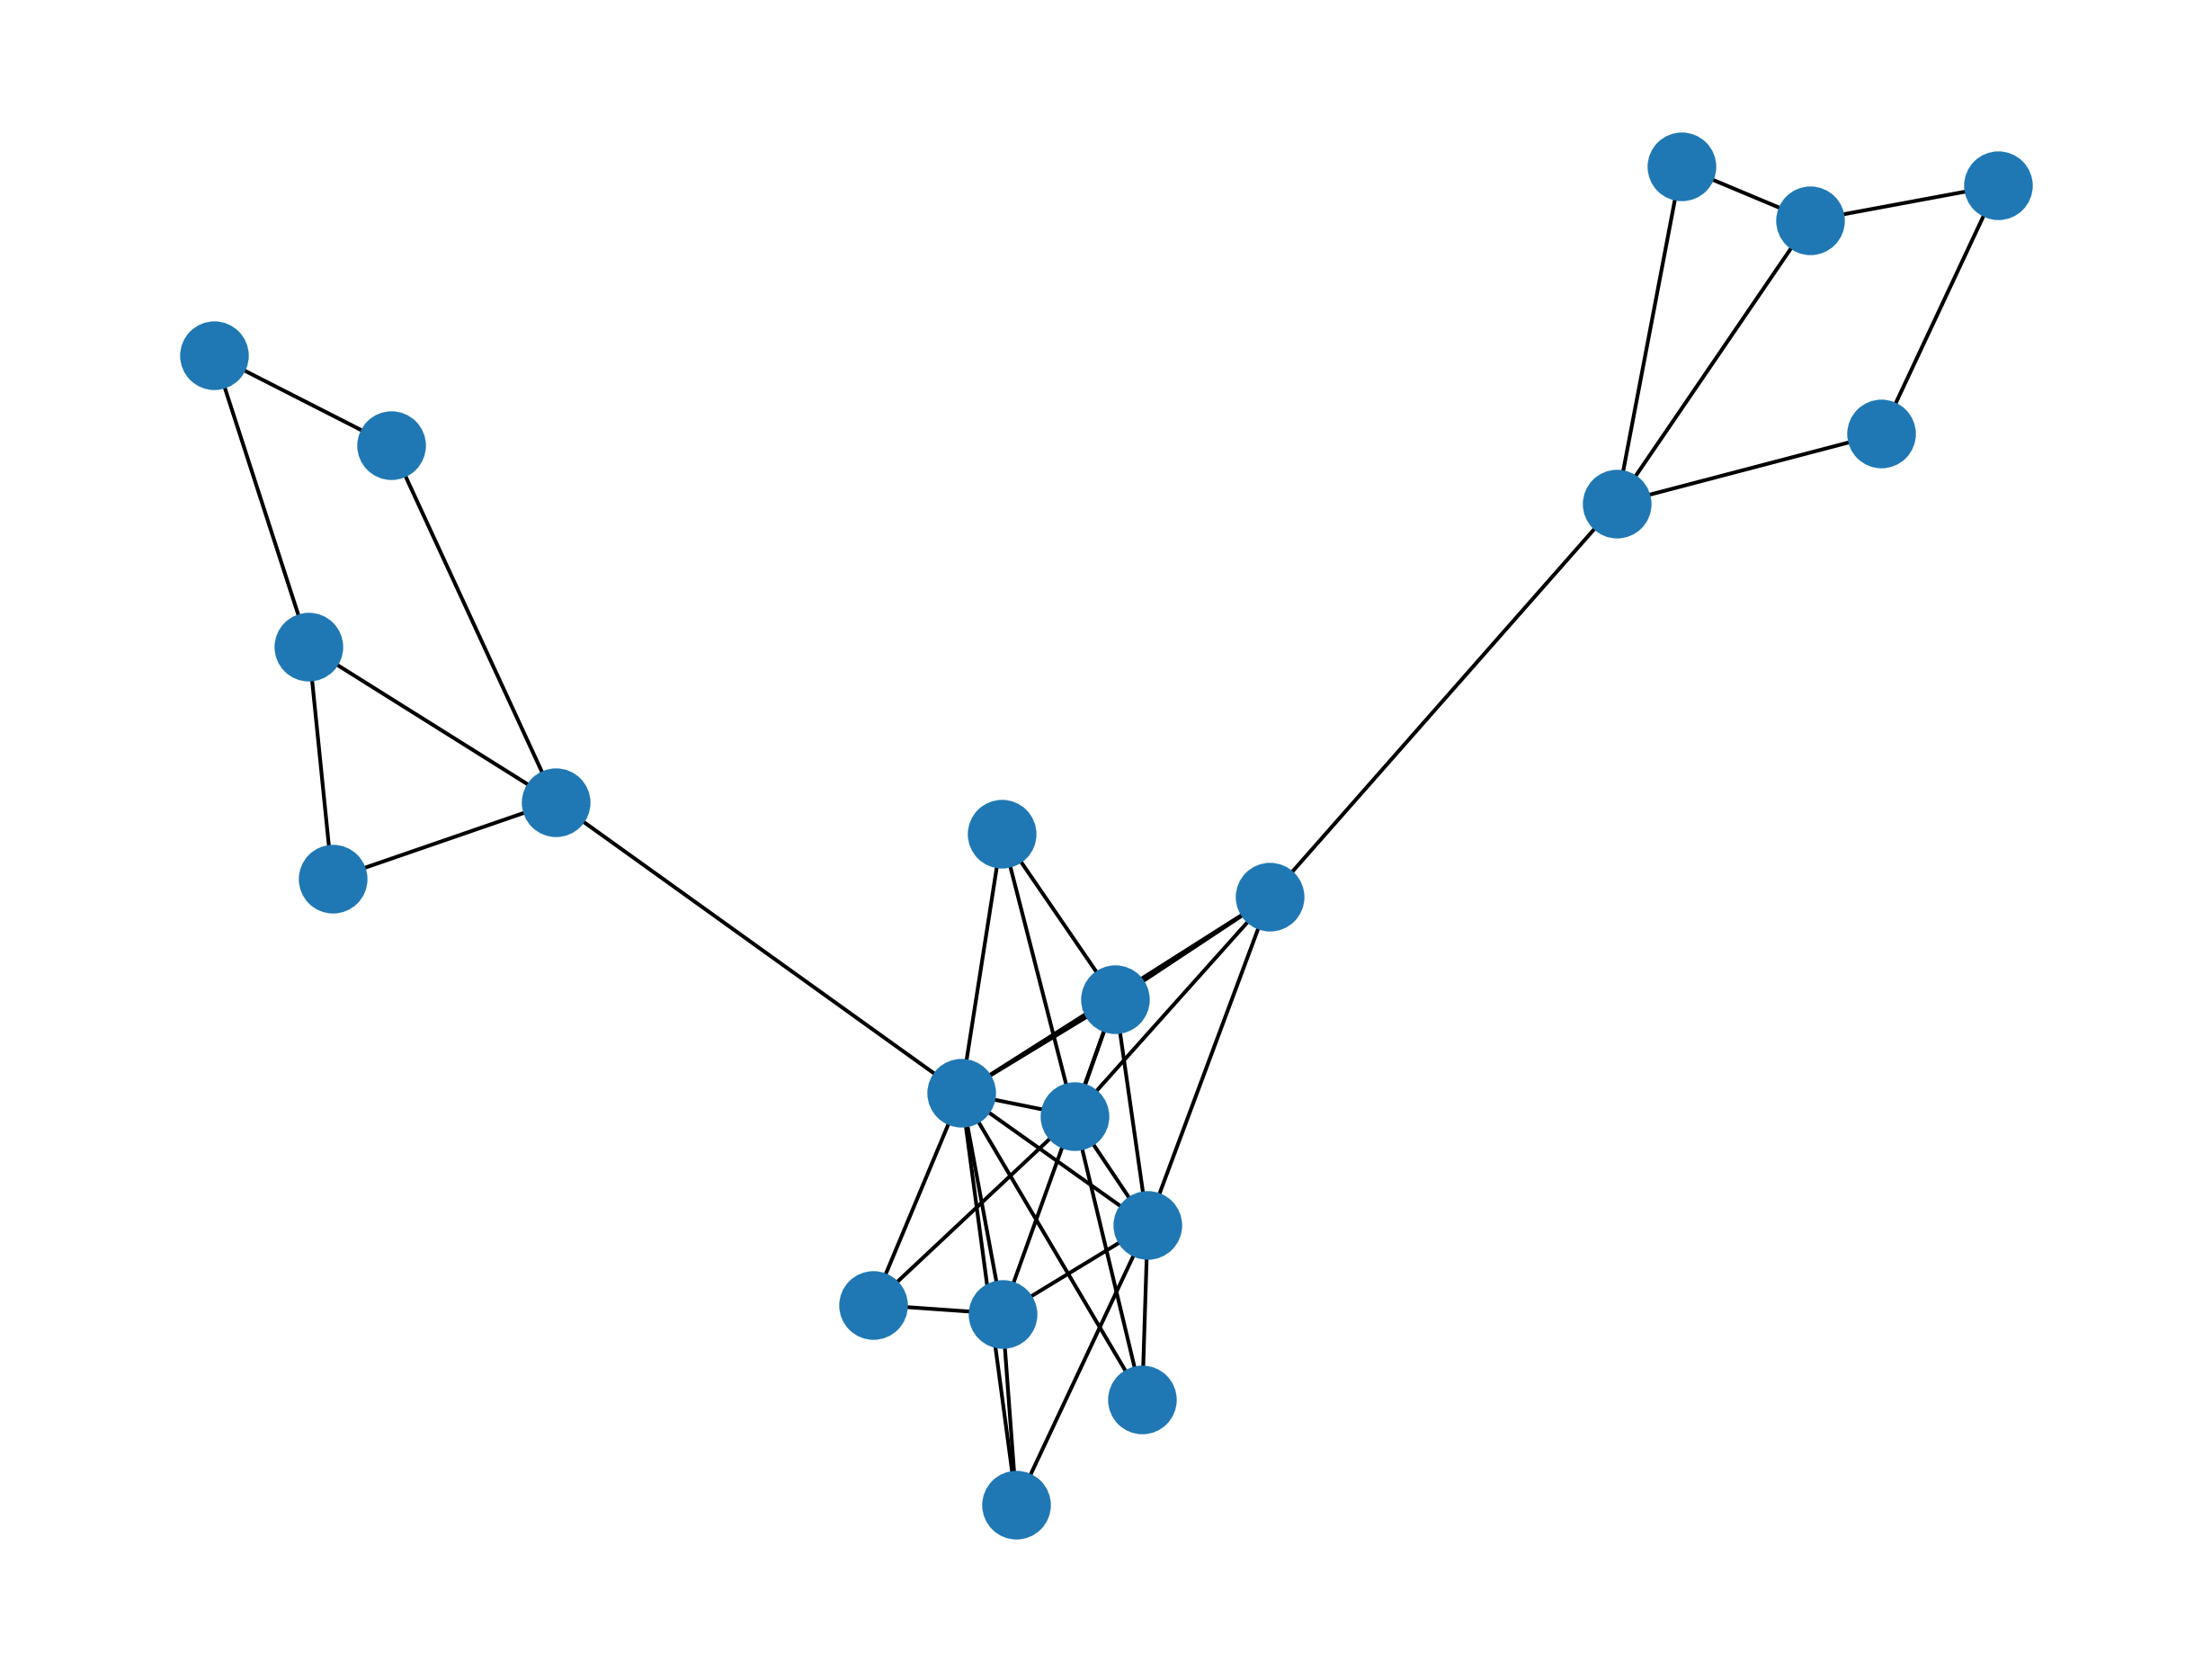

In [12]:
import matplotlib.pyplot as plt
G = nx.dodecahedral_graph()
nx.draw(gengraph.gen_syn1(nb_shapes=2, width_basis=10)[0])  # networkx draw()
plt.draw()  # pyplot draw()
plt.show()